In [1]:
import pandas as pd

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import torch
import numpy as np
import pickle as pk

from tqdm import tqdm_notebook
from sklearn.metrics import cohen_kappa_score
from fastai.vision import *
from torch.nn import functional as F
from utils import *

In [85]:
current_time = get_BJ_time()
print(current_time)

0904_04-09-19


In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

deployment_dir = "../output/inference"

def qk(y_pred, y):
    k = torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
    k[k != k] = 0
    k[torch.isinf(k)] = 0
    
    return k

df_2019_cv = pd.read_csv('../input/aptos-data-split/df_2019_cv.csv')

In [4]:
df_2019_cv.head()

,id_code,diagnosis,path,is_valid1,is_valid2,is_valid3,is_valid4,is_valid5
0,000c1434d8d7,2,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False
1,001639a390f0,4,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False
2,0024cdab0c1e,1,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False
3,002c21358ce6,0,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False
4,005b95c28852,0,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False


In [5]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# Feature Extraction

## Train logits

### b3

In [6]:
b3_models = ["efficientnet-b3_0901_16-45-51_stage2_f1", "efficientnet-b3_0901_16-45-51_stage2_f2",
                  "efficientnet-b3_0901_16-45-51_stage2_f3", "efficientnet-b3_0901_16-45-51_stage2_f4",
                  "efficientnet-b3_0901_16-45-51_stage2_f5"]

b3_train_logits_list = []

for i, m in enumerate(b3_models):
    fold = i + 1
    learn = load_learner(deployment_dir, "{}.pkl".format(m))
    val_df = df_2019_cv[df_2019_cv["is_valid{}".format(fold)]]
    learn.data.add_test(ImageList.from_df(val_df,
                                          '../input/aptos2019-blindness-detection',
                                          cols="id_code",
                                          folder='train_images_ben_preprocessing_sigmaX10',
                                          suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b3_train_logits_list.append(logits)
    np.save("../output/stacking/{}_logits.npy".format(m), logits)

    print(logits.shape)

(731, 1)


### b4

In [7]:
b4_models = ["efficientnet-b4_0820_01-09-57_stage2_f1", "efficientnet-b4_0820_01-09-57_stage2_f2",
                  "efficientnet-b4_0820_01-09-57_stage2_f3", "efficientnet-b4_0820_01-09-57_stage2_f4",
                  "efficientnet-b4_0821_00-02-25_stage2_f5"]

b4_train_logits_list = []
for i, m in enumerate(b4_models):
    fold = i + 1
    learn = load_learner(deployment_dir, "{}.pkl".format(m))
    val_df = df_2019_cv[df_2019_cv["is_valid{}".format(fold)]]
    learn.data.add_test(ImageList.from_df(val_df,
                                          '../input/aptos2019-blindness-detection',
                                          cols="id_code",
                                          folder='train_images_ben_preprocessing_sigmaX10',
                                          suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b4_train_logits_list.append(logits)
    np.save("../output/stacking/{}_logits.npy".format(m), logits)

    print(logits.shape)

(731, 1)


### b5

In [8]:
b5_models = ["efficientnet-b5_0820_01-32-30_stage2_f1", "efficientnet-b5_0903_01-03-41_stage2_f2",
                  "efficientnet-b5_0820_22-13-07_stage2_f3", "efficientnet-b5_0821_01-30-37_stage2_f4",
                  "efficientnet-b5_0821_00-26-51_stage2_f5"]

b5_train_logits_list = []
for i, m in enumerate(b5_models):
    fold = i + 1
    learn = load_learner(deployment_dir, "{}.pkl".format(m))
    val_df = df_2019_cv[df_2019_cv["is_valid{}".format(fold)]]
    learn.data.add_test(ImageList.from_df(val_df,
                                          '../input/aptos2019-blindness-detection',
                                          cols="id_code",
                                          folder='train_images_ben_preprocessing_sigmaX10',
                                          suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b5_train_logits_list.append(logits)
    np.save("../output/stacking/{}_logits.npy".format(m), logits)

    print(logits.shape)

(731, 1)


## Test Feature

### Average

#### b3

In [9]:
b3_test_logits_list = []
for m in b3_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b3_test_logits_list.append(logits)
    
    np.save("../output/stacking/{}_logits_test.npy".format(m), logits)
    print(logits.shape)

(1928, 1)


#### b4

In [10]:
b4_test_logits_list = []
for m in b4_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b4_test_logits_list.append(logits)
    
    np.save("../output/stacking/{}_logits_test.npy".format(m), logits)
    print(logits.shape)

(1928, 1)


#### b5

In [11]:
b5_test_logits_list = []
for m in b5_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))
    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b5_test_logits_list.append(logits)
    
    np.save("../output/stacking/{}_logits_test.npy".format(m), logits)
    print(logits.shape)

(1928, 1)


# Train Stage 2 model on OOF

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [13]:
def qk_np(y, y_pred):
    k = cohen_kappa_score(np.round(y_pred), y, weights='quadratic')
    
    return k

score = make_scorer(qk_np, greater_is_better=True)

In [14]:
np.concatenate(b3_train_logits_list, axis=0).shape

(3662, 1)

In [15]:
X_train = np.concatenate([np.concatenate(b3_train_logits_list, axis=0),
                         np.concatenate(b4_train_logits_list, axis=0),
                         np.concatenate(b5_train_logits_list, axis=0)], axis=1)
y_train = []
n_fold = 5

for i in range(1, n_fold+1):
    label_t = df_2019_cv[df_2019_cv["is_valid{}".format(i)]]["diagnosis"].tolist()
    y_train += label_t
    
print(X_train.shape)

(3662, 3)


## LightGBM 

In [16]:
import lightgbm as lgb

In [92]:
estimator = lgb.LGBMRegressor(n_jobs=8, random_state=SEED)

param_grid = {
#     'max_depth': [3, 5, 7, 9],     
    'max_depth': [5],   
    'learning_rate': [0.05], 
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
#     'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
    'feature_fraction': [0.7],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
#     'bagging_fraction': [0.7],
#     'bagging_freq': [8],
    'bagging_freq': [2, 4, 5, 6, 8],
    'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
#     'lambda_l1': [0],
#     'lambda_l2': [15],
    'lambda_l2': [0, 10, 15, 35, 40],
#     'cat_smooth': [1],
    'cat_smooth': [1, 10, 15, 20, 35],
}

gbm = GridSearchCV(estimator, param_grid, cv=5, n_jobs=16, scoring=score, verbose=1)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Fitting 5 folds for each of 3125 candidates, totalling 15625 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    7.5s
[Parallel(n_jobs=16)]: Done 186 tasks      | elapsed:  1.7min
[Parallel(n_jobs=16)]: Done 437 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done 787 tasks      | elapsed:  7.4min
[Parallel(n_jobs=16)]: Done 1237 tasks      | elapsed: 12.0min
[Parallel(n_jobs=16)]: Done 1787 tasks      | elapsed: 17.0min
[Parallel(n_jobs=16)]: Done 2437 tasks      | elapsed: 23.3min
[Parallel(n_jobs=16)]: Done 3187 tasks      | elapsed: 30.7min
[Parallel(n_jobs=16)]: Done 4037 tasks      | elapsed: 39.2min
[Parallel(n_jobs=16)]: Done 4987 tasks      | elapsed: 48.9min
[Parallel(n_jobs=16)]: Done 6037 tasks      | elapsed: 59.2min
[Parallel(n_jobs=16)]: Done 7187 tasks      | elapsed: 71.1min
[Parallel(n_jobs=16)]: Done 8437 tasks      | elapsed: 84.3min
[Parallel(n_jobs=16)]: Done 9787 tasks      | elapsed: 98.4min
[Parallel(n_jobs=16)]: Done 11237 tasks      

Best parameters found by grid search are: {'bagging_fraction': 0.95, 'bagging_freq': 6, 'cat_smooth': 1, 'feature_fraction': 0.7, 'lambda_l1': 0.1, 'lambda_l2': 0, 'learning_rate': 0.05, 'max_depth': 5}


In [94]:
gbm.cv_results_   

{'mean_fit_time': array([ 0.133504, 47.666323, 72.144339,  8.264116, ...,  2.175546,  2.136839,  2.614567,  1.622754]),
 'std_fit_time': array([4.042595e-02, 4.094134e+01, 4.538825e+01, 1.110526e+01, ..., 1.596149e+00, 1.711502e+00, 1.592605e+00,
        1.013806e+00]),
 'mean_score_time': array([0.012838, 0.072372, 0.056324, 0.053974, ..., 0.027319, 0.003157, 0.002537, 0.033051]),
 'std_score_time': array([0.01826 , 0.043116, 0.029967, 0.03825 , ..., 0.027541, 0.001011, 0.000151, 0.041582]),
 'param_bagging_fraction': masked_array(data=[0.6, 0.6, 0.6, 0.6, ..., 0.95, 0.95, 0.95, 0.95],
              mask=[False, False, False, False, ..., False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_bagging_freq': masked_array(data=[2, 2, 2, 2, ..., 8, 8, 8, 8],
              mask=[False, False, False, False, ..., False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_cat_smooth': masked_array(data=[1, 1, 1, 1, ..., 35, 35, 3

In [95]:
print(gbm.best_score_, qk_np(y_train, xlf.predict(X_train)))

0.9253003486640811 0.9360609597886036


In [96]:
model_save_name = "lightgbm-{}".format(current_time)

with open(os.path.join(deployment_dir, model_save_name+".pkl"), "wb") as f:
    pk.dump(gbm.best_estimator_, f)

print(model_save_name)

lightgbm-0904_04-09-19


## XGBoost 

In [33]:
import xgboost as xgb

In [44]:
estimator_xgb = xgb.XGBRegressor(n_jobs=8, random_state=SEED)

parameters = {
              'max_depth': [3],
              'learning_rate': [0.1],
#               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'min_child_weight': [20],
#               'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [2],
#               'max_delta_step': [0, 0.2, 0.6, 1, 2],
              'subsample': [0.8],
#               'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.7],
#               'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_alpha': [0],
#               'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
              'reg_lambda': [0.6],
#               'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
              'scale_pos_weight': [0.8]
#               'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]
}

xlf = GridSearchCV(estimator_xgb, parameters, cv=5, n_jobs=16, scoring=score, verbose=1)
xlf.fit(X_train, y_train)

print('Best parameters found by grid search are:', xlf.best_params_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   27.9s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  4.0min


Best parameters found by grid search are: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 3, 'min_child_weight': 20, 'reg_alpha': 0, 'reg_lambda': 0.6, 'scale_pos_weight': 0.8, 'subsample': 0.8}


[Parallel(n_jobs=16)]: Done 625 out of 625 | elapsed:  5.8min finished


In [45]:
xlf.cv_results_ 

{'mean_fit_time': array([16.576894, 19.437918, 24.421603,  7.953644, ...,  3.725325,  2.692475,  1.895665,  1.726808]),
 'std_fit_time': array([5.719804, 7.203137, 5.606267, 4.825887, ..., 0.258053, 0.426859, 0.324031, 0.263813]),
 'mean_score_time': array([0.389374, 0.853573, 0.906028, 0.447795, ..., 0.974211, 1.474732, 1.209976, 1.393587]),
 'std_score_time': array([0.327546, 0.909945, 0.826804, 0.317137, ..., 0.33777 , 0.426922, 0.727559, 0.281498]),
 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7, 0.7],
              mask=[False, False, False, False, ..., False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, ..., False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_delta_step': masked_array(data=[2, 2, 2, 2, ..., 2, 2, 2, 2],
              mask=

In [46]:
print(xlf.best_score_, qk_np(y_train, xlf.predict(X_train)))

0.9275440917207455 0.9360609597886036


In [47]:
model_save_name = "xgboost-{}".format(current_time)

with open(os.path.join(deployment_dir, model_save_name+".pkl"), "wb") as f:
    pk.dump(xlf.best_estimator_, f)

print(model_save_name)

xgboost-0903_05-26-03


## SVR 

In [50]:
from sklearn.svm import SVR

In [51]:
estimator_svr = SVR()

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svr = GridSearchCV(estimator_svr, tuned_parameters, cv=5, n_jobs=16, scoring=score, verbose=1)
svr.fit(X_train, y_train)

print('Best parameters found by grid search are:', svr.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done  60 out of  60 | elapsed:  1.7min finished


Best parameters found by grid search are: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [52]:
svr.cv_results_ 

{'mean_fit_time': array([ 0.449111,  0.725864,  0.449926,  0.404292,  0.408877,  0.384097,  0.534327,  0.382056,  0.464625,  1.704576,
        10.272197, 88.658682]),
 'std_fit_time': array([3.030703e-02, 2.183755e-02, 8.633045e-02, 1.061797e-01, 3.863933e-03, 4.550244e-03, 1.438193e-02, 1.364801e-02,
        3.683297e-02, 1.674361e-01, 1.229205e+00, 6.570119e+00]),
 'mean_score_time': array([0.037776, 0.053958, 0.035569, 0.032954, 0.035365, 0.034078, 0.027068, 0.026811, 0.008165, 0.009239, 0.008616,
        0.009378]),
 'std_score_time': array([0.002869, 0.007793, 0.007139, 0.003456, 0.003501, 0.006972, 0.000804, 0.000662, 0.000259, 0.001165, 0.000126,
        0.001421]),
 'param_C': masked_array(data=[1, 1, 10, 10, 100, 100, 1000, 1000, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.001, 0.0001, 0.001, 0.0001, 0.001, 0.0

In [53]:
print(svr.best_score_, qk_np(y_train, svr.predict(X_train)))

0.9255694040131046 0.9251493380866914


In [54]:
model_save_name = "svr-{}".format(current_time)

with open(os.path.join(deployment_dir, model_save_name+".pkl"), "wb") as f:
    pk.dump(xlf.best_estimator_, f)

print(model_save_name)

svr-0903_05-26-03


# Test

## LightGBM 

In [77]:
# model_save_name = "lightgbm-0903_05-26-03"

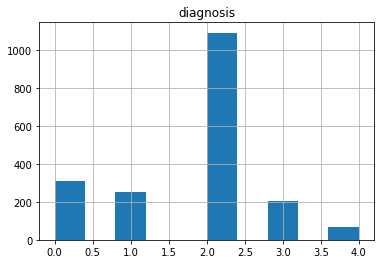

../output/submission/lightgbm-0904_04-09-19-5-fold_avg_logits_test.csv


In [98]:
b3_test_avg_feats = np.average(b3_test_logits_list, axis=0)
b4_test_avg_feats = np.average(b4_test_logits_list, axis=0)
b5_test_avg_feats = np.average(b5_test_logits_list, axis=0)


X_test = np.concatenate([b3_test_avg_feats, b4_test_avg_feats, b5_test_avg_feats], axis=1)
y_pred = gbm.predict(X_test)

y_pred = np.round(y_pred)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_avg_logits_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

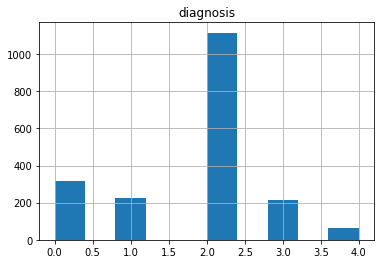

../output/submission/lightgbm-0904_04-09-19-5-fold_logits_avg_test.csv


In [100]:
# 5 test feature then avg

results = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    res = gbm.predict(X_test)
    results.append(res)

avg_res_gbm = np.average(results, axis=0)
np.save("../output/submission/{}-5-fold_logits_avg_test_logits.npy".format(model_save_name), avg_res_gbm)
y_pred = np.round(avg_res_gbm)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_logits_avg_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

## XGBoost 

In [101]:
model_save_name = "xgboost-0903_05-26-03"

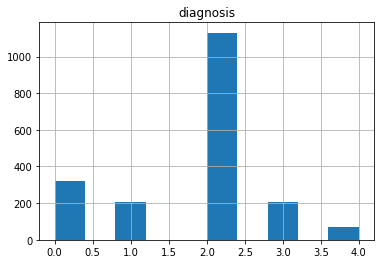

../output/submission/xgboost-0903_05-26-03-5-fold_avg_logits_test.csv


In [48]:
b3_test_avg_feats = np.average(b3_test_logits_list, axis=0)
b4_test_avg_feats = np.average(b4_test_logits_list, axis=0)
b5_test_avg_feats = np.average(b5_test_logits_list, axis=0)


X_test = np.concatenate([b3_test_avg_feats, b4_test_avg_feats, b5_test_avg_feats], axis=1)
y_pred = xlf.predict(X_test)

y_pred = np.round(y_pred)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_avg_logits_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

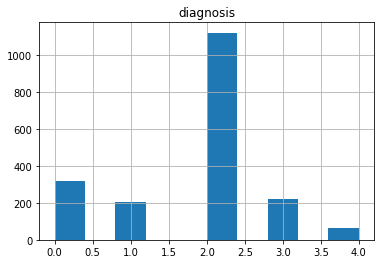

../output/submission/xgboost-0903_05-26-03-5-fold_logits_avg_test.csv


In [102]:
# 5 test feature then avg
results = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    res = xlf.predict(X_test)
    results.append(res)

avg_res_xlf = np.average(results, axis=0)
np.save("../output/submission/{}-5-fold_logits_avg_test_logits.npy".format(model_save_name), avg_res_xlf)
y_pred = np.round(avg_res_xlf)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_logits_avg_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

## SVR 

In [103]:
model_save_name = "svr-0903_05-26-03"

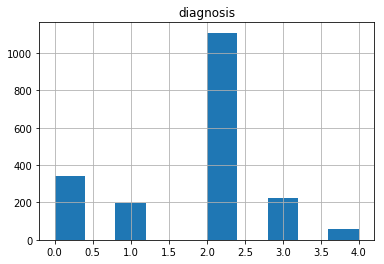

../output/submission/svr-0903_05-26-03-5-fold_avg_logits_test.csv


In [55]:
b3_test_avg_feats = np.average(b3_test_logits_list, axis=0)
b4_test_avg_feats = np.average(b4_test_logits_list, axis=0)
b5_test_avg_feats = np.average(b5_test_logits_list, axis=0)


X_test = np.concatenate([b3_test_avg_feats, b4_test_avg_feats, b5_test_avg_feats], axis=1)
y_pred = svr.predict(X_test)

y_pred = np.round(y_pred)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_avg_logits_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

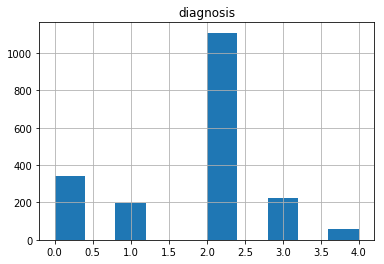

../output/submission/svr-0903_05-26-03-5-fold_logits_avg_test.csv


In [104]:
# 5 test feature then avg

results = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    res = svr.predict(X_test)
    results.append(res)

avg_res_svr = np.average(results, axis=0)
np.save("../output/submission/{}-5-fold_logits_avg_test_logits.npy".format(model_save_name), avg_res_svr)
y_pred = np.round(avg_res_svr)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_logits_avg_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

# Correlation Analysis

In [99]:
np.corrcoef([avg_res_gbm, avg_res_xlf, avg_res_svr])

array([[1.      , 0.998509, 0.997369],
       [0.998509, 1.      , 0.997143],
       [0.997369, 0.997143, 1.      ]])